In [76]:
%pylab inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim
from sklearn.utils import shuffle
from scipy import optimize
from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torchvision import transforms
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_circles
from matplotlib.colors import ListedColormap

Populating the interactive namespace from numpy and matplotlib


C:\Users\46145\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['poly', 'shuffle']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [129]:
model = nn.Linear(2, 1)
model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [201]:
def train(X, Y, model, epochs = 100, batchsize = 10, alpha = 0.01):
    X = torch.FloatTensor(X)
    Y = torch.FloatTensor(Y)
    N = len(Y)

    for epoch in range(epochs):
        perm = torch.randperm(N)
        sum_loss = 0

        for i in range(0, N, batchsize):
            x = X[perm[i : i + batchsize]].cuda()
            y = Y[perm[i : i + batchsize]].cuda()

            optimizer.zero_grad()
            #print(i)
            output = model(x).squeeze()
            weight = model.weight.squeeze()

            loss = torch.mean(torch.clamp(1 - y * output, min=0))
            loss += alpha * (weight.t() @ weight) / 2.0

            loss.backward()
            optimizer.step()

            sum_loss += float(loss)
#         x = torch.FloatTensor(x_val).cuda()
#         y = torch.FloatTensor(y_val).cuda()
#         output = model(x).squeeze()
#         vloss = torch.mean(torch.clamp(1 - y * output, min=0))
#         vloss += alpha * (weight.t() @ weight) / 2.0        
        #print("Epoch: {:4d}\tloss: {}".format(epoch, vloss / N))

In [111]:
class KernelSvmClassifier:
    
    def __init__(self, C, kernel):
        self.C = C                               
        self.kernel = kernel          # <---
        self.alpha = None
        self.supportVectors = None
        self.lam = 0.00001
    
    def fit(self, X, y):
        N = len(y)
        H = np.apply_along_axis(lambda x1 : np.apply_along_axis(lambda x2:  self.kernel(x1, x2), 1, X),
                                  1, X)   
        yt = y.reshape(-1, 1)
        Gram = H * np.matmul(yt, yt.T) + self.lam * np.identity(N)

        def Ld0(G, alpha):
            return alpha.sum() - 0.5 * alpha.dot(alpha.dot(G))

        def Ld0dAlpha(G, alpha):
            return np.ones_like(alpha) - alpha.dot(G)

        A = np.vstack((-np.eye(N), np.eye(N)))      
        b = np.hstack((np.zeros(N), self.C * np.ones(N)))
        constraints = ({'type': 'eq',   'fun': lambda a: np.dot(a, y),     'jac': lambda a: y},
                       {'type': 'ineq', 'fun': lambda a: b - np.dot(A, a), 'jac': lambda a: -A})

        # Maximize by minimizing the opposite
        optRes = optimize.minimize(fun=lambda a: -Ld0(Gram, a),
                                   x0=np.ones(N), 
                                   method='SLSQP', 
                                   jac=lambda a: -Ld0dAlpha(Gram, a), 
                                   constraints=constraints)
        self.alpha = optRes.x
        # --->
        epsilon = 1e-8
        supportIndices = self.alpha > epsilon
        self.supportVectors = X[supportIndices]
        self.supportAlphaY = y[supportIndices] * self.alpha[supportIndices]
        # <---
    
    def predict(self, X):
        def predict1(x):
            x1 = np.apply_along_axis(lambda s: self.kernel(s, x), 1, self.supportVectors)
            x2 = x1 * self.supportAlphaY
            return np.sum(x2)
        
        d = np.apply_along_axis(predict1, 1, X)
        return 2 * (d > 0) - 1
        # <---



In [171]:
mu = 2.5
cov = np.identity(2)

In [172]:
sample_pos = np.random.multivariate_normal([mu,0], cov, 750)
sample_neg = np.random.multivariate_normal([-mu,0], cov, 750)

In [184]:
whole = np.concatenate((sample_pos, sample_neg))
labels = np.concatenate((np.ones(750), -np.ones(750)))
whole, labels = shuffle(whole, labels)

In [185]:
x_train = whole[:1000]
y_train = labels[:1000]
x_val = whole[1000:1250]
y_val = labels[1000:1250]
x_test = whole[1250:]
y_test = labels[1250:]

In [190]:
model = nn.Linear(2, 1)
model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.train()
train(x_train, y_train, model, epochs=100)


Epoch:    0	loss: 0.002091767964884639
Epoch:    1	loss: 0.0018436023965477943
Epoch:    2	loss: 0.0015940670855343342
Epoch:    3	loss: 0.001344797434285283
Epoch:    4	loss: 0.0010971535230055451
Epoch:    5	loss: 0.0008574508829042315
Epoch:    6	loss: 0.000656687596347183
Epoch:    7	loss: 0.00050628453027457
Epoch:    8	loss: 0.00037088748649694026
Epoch:    9	loss: 0.00026307953521609306
Epoch:   10	loss: 0.00019360751321073622
Epoch:   11	loss: 0.00015395291848108172
Epoch:   12	loss: 0.0001328974758507684
Epoch:   13	loss: 0.00011848964641103521
Epoch:   14	loss: 0.00010848270903807133
Epoch:   15	loss: 0.0001000376942101866
Epoch:   16	loss: 9.360046533402056e-05
Epoch:   17	loss: 8.867369615472853e-05
Epoch:   18	loss: 8.385814726352692e-05
Epoch:   19	loss: 7.969571743160486e-05
Epoch:   20	loss: 7.580856618005782e-05
Epoch:   21	loss: 7.231851486722007e-05
Epoch:   22	loss: 6.925963680259883e-05
Epoch:   23	loss: 6.625645619351417e-05
Epoch:   24	loss: 6.376355304382741e-05

In [89]:
def visualize(X, Y, model, label = "Default"):
    W = model.weight.squeeze().detach().cpu().numpy()
    b = model.bias.squeeze().detach().cpu().numpy()
    #z = W.dot(X) + b
    
    plt.figure(figsize=(10, 10))
    plt.scatter(x=X[:, 0], y=X[:, 1], c=Y, s=10)
    x0 = np.linspace(-5,5)
    y0 = -(W[0]*x0+b)/W[1]
    plt.plot(x0, y0, '-r', label='Boundary')
    #plt.contourf(x, y, z, alpha=0.8, cmap="Greys")
    plt.ylim([-5, 5])
    plt.title(label)
    plt.tight_layout()
    plt.show()

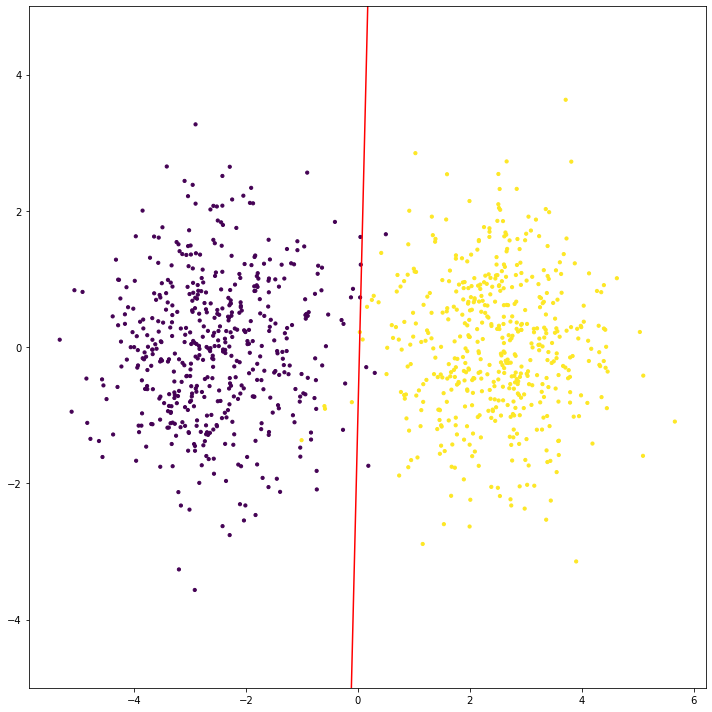

In [205]:
visualize(x_train, y_train, model)

In [6]:
def test_model(X, Y, model):
    W = model.weight.squeeze().detach().cpu().numpy()
    b = model.bias.squeeze().detach().cpu().numpy()
    z = W.dot(np.transpose(X)) + b
    result = np.sign(z)
    acc = [Y[i] == result[i] for i in range(len(Y))]
    return sum(acc)/len(Y)
    

In [220]:
test_model(x_test, y_test, model)

0.996

In [11]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        h = self.linear(x)
        outputs = torch.sigmoid(h)
        
        #print(outputs)
        return outputs

In [339]:
lr = LogisticRegression(2,1)
optimizer = optim.Adam(lr.parameters(), lr=0.001)
lr.train()
batchsize = 20
losses = []
criterion = nn.CrossEntropyLoss()
for epoch in range(100):
    for i in range(0, 1000, batchsize):
        x = torch.FloatTensor(x_train[i : i + batchsize])
        y = torch.Tensor(y_train[i : i + batchsize])
        yb = (y+1)/2
        optimizer.zero_grad()
        output = lr(x)
#         print(torch.log(output))
#         print()
        loss = -torch.mean(yb*torch.log(output)+(1-yb)*torch.log(1-output))
        
        tmp = loss.item()
        losses.append(tmp)
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        # Display
        if i % 50 == 0:
            print('\r Train Epoch: {} \tLoss: {:.6f}'.format(
                epoch, 

                loss.item()), 
                end='')
            
    print()

 Train Epoch: 0 	Loss: 0.900788
 Train Epoch: 1 	Loss: 0.862240
 Train Epoch: 2 	Loss: 0.828131
 Train Epoch: 3 	Loss: 0.798581
 Train Epoch: 4 	Loss: 0.773546
 Train Epoch: 5 	Loss: 0.752836
 Train Epoch: 6 	Loss: 0.736125
 Train Epoch: 7 	Loss: 0.722987
 Train Epoch: 8 	Loss: 0.712931
 Train Epoch: 9 	Loss: 0.705442
 Train Epoch: 10 	Loss: 0.700021
 Train Epoch: 11 	Loss: 0.696213
 Train Epoch: 12 	Loss: 0.693624
 Train Epoch: 13 	Loss: 0.691929
 Train Epoch: 14 	Loss: 0.690870
 Train Epoch: 15 	Loss: 0.690251
 Train Epoch: 16 	Loss: 0.689927
 Train Epoch: 17 	Loss: 0.689795
 Train Epoch: 18 	Loss: 0.689783
 Train Epoch: 19 	Loss: 0.689844
 Train Epoch: 20 	Loss: 0.689944
 Train Epoch: 21 	Loss: 0.690065
 Train Epoch: 22 	Loss: 0.690193
 Train Epoch: 23 	Loss: 0.690321
 Train Epoch: 24 	Loss: 0.690445
 Train Epoch: 25 	Loss: 0.690563
 Train Epoch: 26 	Loss: 0.690672
 Train Epoch: 27 	Loss: 0.690773
 Train Epoch: 28 	Loss: 0.690866
 Train Epoch: 29 	Loss: 0.690951
 Train Epoch: 30 	Lo

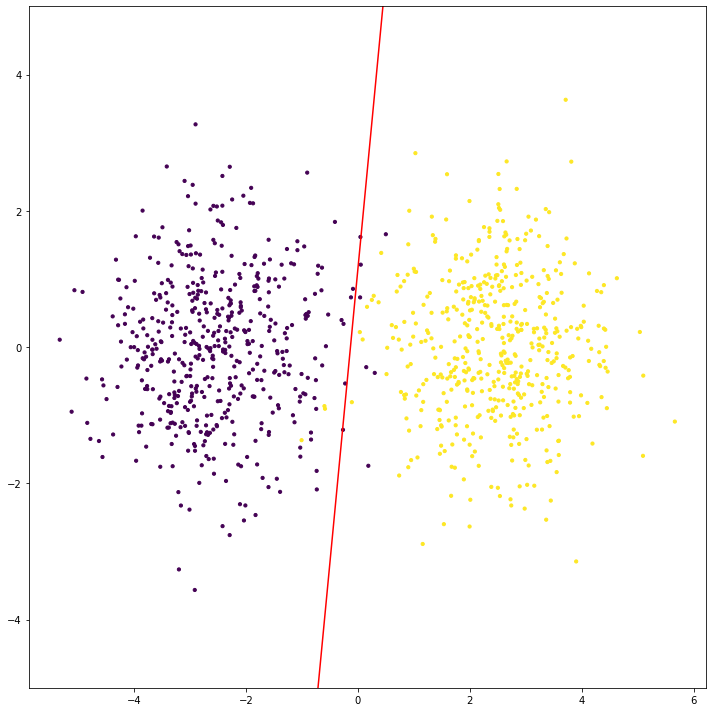

In [342]:
visualize(x_train, y_train, lr.linear)


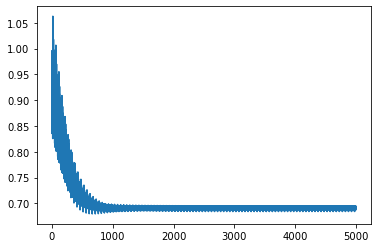

In [340]:
plt.plot(losses)

In [349]:
output = lr(torch.FloatTensor(x_test))
y_pred = [i>=0.5 for i in output]
y_b = (y_test+1)/2
(y_b == y_pred).sum()/250

<ipython-input-349-0d7082cd0487>:4: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  (y_b == y_pred).sum()/250
<ipython-input-349-0d7082cd0487>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  (y_b == y_pred).sum()/250


0.996

In [291]:

neigh = KNeighborsClassifier(n_neighbors=10)
neigh.fit(x_train, y_train)

#print(neigh.predict([[1.1]]))

#print(neigh.predict_proba([[0.9]]))

KNeighborsClassifier(n_neighbors=10)

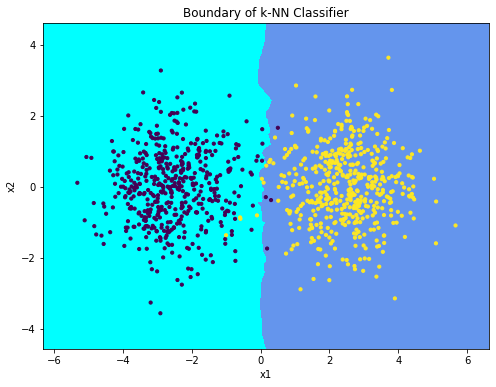

In [305]:

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
cmap_light = ListedColormap(["cyan", "cornflowerblue"])
cmap_bold = ["darkorange", "c", "darkblue"]
h = 0.02
x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = neigh.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot

Z = Z.reshape(xx.shape)
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, cmap= cmap_light)

# Plot also the training points
plt.scatter(x=x_train[:, 0], y=x_train[:, 1], c=y_train, s=10)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("Boundary of k-NN Classifier")
plt.xlabel("x1")
plt.ylabel("x2")

plt.show()

In [303]:

X = x_train
y = y_train
gnb = GaussianNB()
y_pred = gnb.fit(X, y).predict(x_test)
print("Number of mislabeled points out of a total %d points : %d"
      % (x_test.shape[0], (y_test == y_pred).sum()))
(y_test == y_pred).sum()/250

Number of mislabeled points out of a total 250 points : 249


0.996

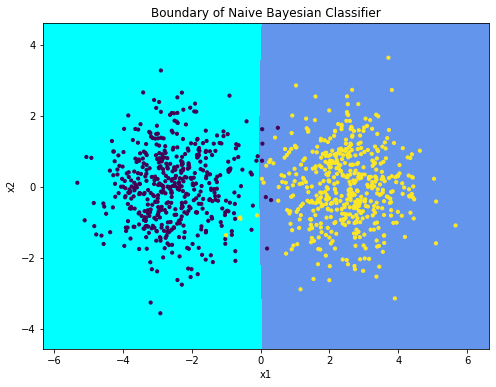

In [306]:
cmap_light = ListedColormap(["cyan", "cornflowerblue"])
cmap_bold = ["darkorange", "c", "darkblue"]
h = 0.02
x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = gnb.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot

Z = Z.reshape(xx.shape)
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, cmap= cmap_light)

# Plot also the training points
plt.scatter(x=x_train[:, 0], y=x_train[:, 1], c=y_train, s=10)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("Boundary of Naive Bayesian Classifier")
plt.xlabel("x1")
plt.ylabel("x2")

plt.show()

In [31]:
acc_svm = []
acc_lr = []
acc_knn = []
acc_nb = []

for i in range(8):
    mu = 1+0.2*i
    cov = np.identity(2)
    sample_pos = np.random.multivariate_normal([mu,0], cov, 750)
    sample_neg = np.random.multivariate_normal([-mu,0], cov, 750)
    whole = np.concatenate((sample_pos, sample_neg))
    labels = np.concatenate((np.ones(750), -np.ones(750)))
    whole, labels = shuffle(whole, labels)
    x_train = whole[:1000]
    y_train = labels[:1000]
    x_val = whole[1000:1250]
    y_val = labels[1000:1250]
    x_test = whole[1250:]
    y_test = labels[1250:]
    
    #Linear SVM
    model = nn.Linear(2, 1)
    model.cuda()
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train(x_train, y_train, model, epochs=20)
    acc = test_model(x_test, y_test, model)
    acc_svm.append(acc)
        
    #Logistic Regression
    lr = LogisticRegression(2,1)
    optimizer = optim.Adam(lr.parameters(), lr=0.001)
    lr.train()
    batchsize = 20
    for epoch in range(10):
        for i in range(0, 1000, batchsize):
            x = torch.FloatTensor(x_train[i : i + batchsize])
            y = torch.Tensor(y_train[i : i + batchsize])
            yb = (y+1)/2
            optimizer.zero_grad()
            output = lr(x)
            loss = -torch.mean(yb*torch.log(output)+(1-yb)*torch.log(1-output))
            # Backpropagation
            loss.backward()
            optimizer.step()
    output = lr(torch.FloatTensor(x_test))
    y_pred = [i>=0.5 for i in output]
    y_b = (y_test+1)/2
    acc_lr.append(sum(y_b == y_pred)/250)
    
    # KNN
    neigh = KNeighborsClassifier(n_neighbors=10)
    neigh.fit(x_train, y_train)
    output = neigh.predict(x_test)
    acc_knn.append(sum(y_test == output)/250)
    
    # Naive Bayes
    gnb = GaussianNB()
    y_pred = gnb.fit(x_train, y_train).predict(x_test)
    acc_nb.append(sum(y_test == y_pred)/250)
    
    

<ipython-input-31-2d557aea7dfb>:49: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  acc_lr.append(sum(y_b == y_pred)/250)
<ipython-input-31-2d557aea7dfb>:49: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  acc_lr.append(sum(y_b == y_pred)/250)
<ipython-input-31-2d557aea7dfb>:49: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the co

Text(0, 0.5, 'acc')

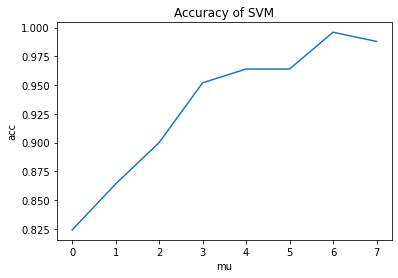

In [27]:
plt.plot(acc_svm)
plt.title("Accuracy of SVM")
plt.xlabel("mu")
plt.ylabel("acc")

Text(0, 0.5, 'acc')

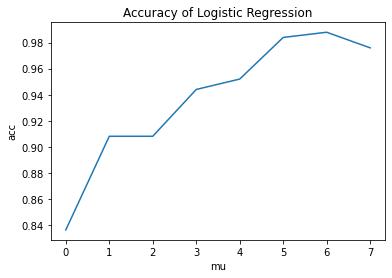

In [34]:
plt.plot(acc_lr)
plt.title("Accuracy of Logistic Regression")
plt.xlabel("mu")
plt.ylabel("acc")

Text(0, 0.5, 'acc')

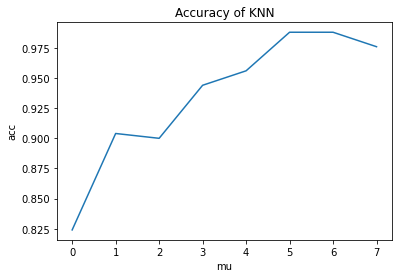

In [33]:
plt.plot(acc_knn)
plt.title("Accuracy of KNN")
plt.xlabel("mu")
plt.ylabel("acc")

Text(0, 0.5, 'acc')

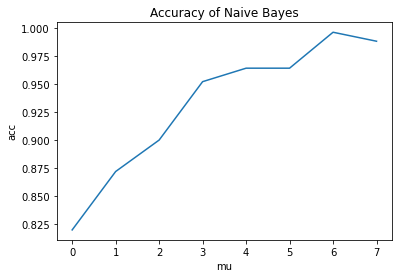

In [30]:
plt.plot(acc_nb)
plt.title("Accuracy of Naive Bayes")
plt.xlabel("mu")
plt.ylabel("acc")

In [306]:
whole, labels = make_circles(n_samples=1500)
labels = (labels - 0.5)*2
x_train = whole[:1000]
y_train = labels[:1000]
x_val = whole[1000:1250]
y_val = labels[1000:1250]
x_test = whole[1250:]
y_test = labels[1250:]

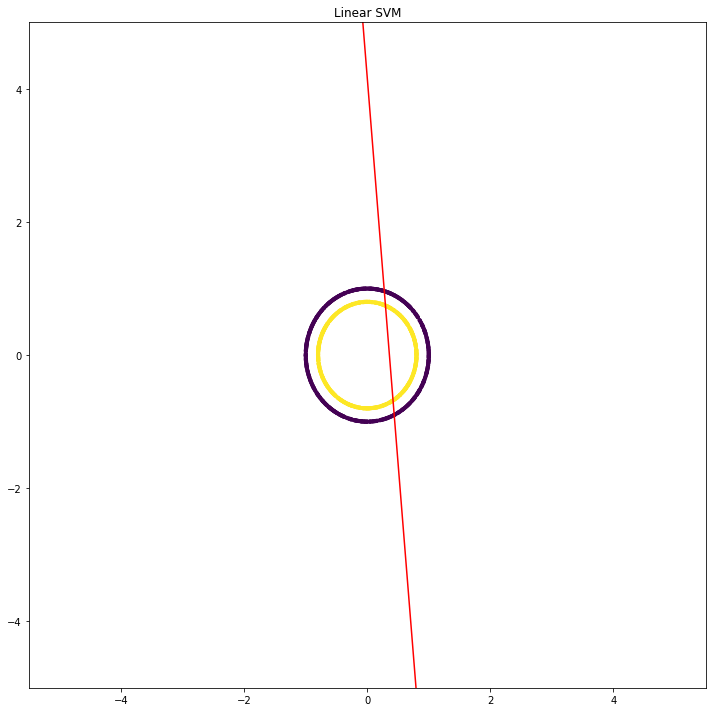

0.46

In [90]:
#Linear SVM
model = nn.Linear(2, 1)
model.cuda()
model.train()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train(x_train, y_train, model, epochs=20)
visualize(x_train, y_train, model, "Linear SVM")
acc = test_model(x_test, y_test, model)
acc

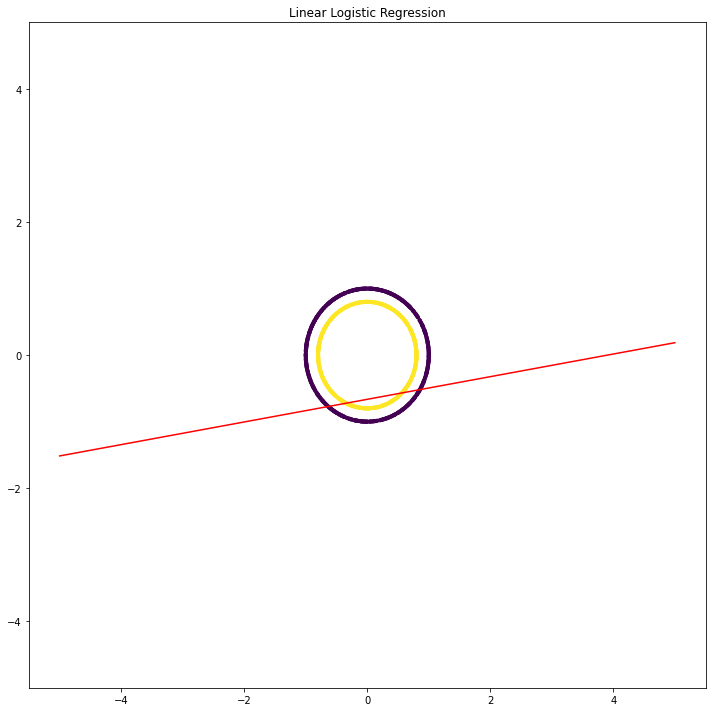

<ipython-input-91-78c99a629473>:21: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  acc = (sum(y_b == y_pred)/250)
<ipython-input-91-78c99a629473>:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  acc = (sum(y_b == y_pred)/250)


0.44

In [91]:
#Logistic Regression
lr = LogisticRegression(2,1)
optimizer = optim.Adam(lr.parameters(), lr=0.001)
lr.train()
batchsize = 20
for epoch in range(10):
    for i in range(0, 1000, batchsize):
        x = torch.FloatTensor(x_train[i : i + batchsize])
        y = torch.Tensor(y_train[i : i + batchsize])
        yb = (y+1)/2
        optimizer.zero_grad()
        output = lr(x)
        loss = -torch.mean(yb*torch.log(output)+(1-yb)*torch.log(1-output))
        # Backpropagation
        loss.backward()
        optimizer.step()
visualize(x_train, y_train, lr.linear, "Linear Logistic Regression")
output = lr(torch.FloatTensor(x_test))
y_pred = [i>=0.5 for i in output]
y_b = (y_test+1)/2
acc = (sum(y_b == y_pred)/250)
acc

In [112]:
def RBF(x1, x2):
    diff = x1 - x2
    return np.exp(-np.dot(diff, diff) * len(x1) / 2)

c = 0
d = 2
def poly(x1, x2):
    return (np.dot(x1,x2)+c)**d

KSC = KernelSvmClassifier(C=0.001, kernel=RBF)
KSC.fit(x_train, y_train)

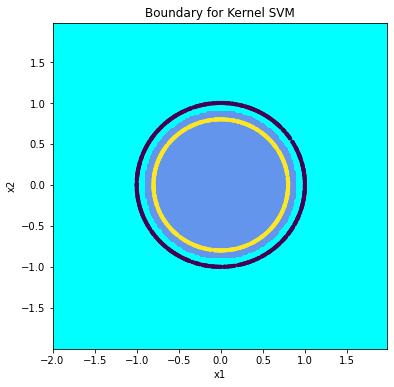

In [119]:
cmap_light = ListedColormap(["cyan", "cornflowerblue"])
cmap_bold = ["darkorange", "c", "darkblue"]
h = 0.02
x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = KSC.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot

Z = Z.reshape(xx.shape)
plt.figure(figsize=(6, 6))
plt.contourf(xx, yy, Z, cmap= cmap_light)

# Plot also the training points
plt.scatter(x=x_train[:, 0], y=x_train[:, 1], c=y_train, s=10)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("Boundary for Kernel SVM")
plt.xlabel("x1")
plt.ylabel("x2")

plt.show()

In [117]:
y_pred = KSC.predict(x_test)
(y_test == y_pred).sum()/250

1.0

In [130]:
KSC = KernelSvmClassifier(C=0.001, kernel=poly)
KSC.fit(x_train, y_train)
y_pred = clf.predict(x_test)
(y_test == y_pred).sum()/250

1.0

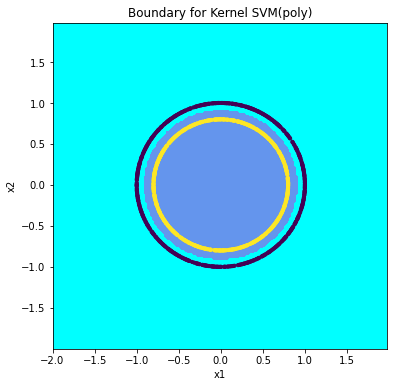

In [131]:
cmap_light = ListedColormap(["cyan", "cornflowerblue"])
cmap_bold = ["darkorange", "c", "darkblue"]
h = 0.02
x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = KSC.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot

Z = Z.reshape(xx.shape)
plt.figure(figsize=(6, 6))
plt.contourf(xx, yy, Z, cmap= cmap_light)

# Plot also the training points
plt.scatter(x=x_train[:, 0], y=x_train[:, 1], c=y_train, s=10)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("Boundary for Kernel SVM(poly)")
plt.xlabel("x1")
plt.ylabel("x2")

plt.show()

In [171]:
class NNModel(nn.Module):
    def __init__(self, indim, outdim):
        super(NNModel, self).__init__()
        
        self.fc1 = nn.Linear(indim, 300)
        
        self.fc2 = nn.Linear(300, outdim)
        
    def forward(self, x):
        h = self.fc1(x)    
        sh = F.sigmoid(h)
        z = self.fc2(sh)
        out = F.softmax(z)
        return out


In [177]:
nnmodel = NNModel(2,2)
optimizer = optim.Adam(nnmodel.parameters(), lr=0.001)
nnmodel.train()

losses = []
batchsize = 20
for epoch in range(100):
    for i in range(0, 1000, batchsize):
        x = torch.FloatTensor(x_train[i : i + batchsize])
        y = torch.Tensor(y_train[i : i + batchsize])
        yb = (y+1)/2
        optimizer.zero_grad()
        y_pred = nnmodel(x) 
        loss = celoss(y_pred, yb.long())
        loss.backward()
        optimizer.step()
    output = nnmodel(torch.FloatTensor(x_val))
    y_pred = [i[1]>=i[0] for i in output]
    y_b = (y_val+1)/2
    losses.append(sum(y_b == y_pred)/250)
    print(losses[-1])

C:\Users\46145\anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
<ipython-input-171-398bdfac6018>:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(z)


0.528
0.528
0.528
0.528
0.528
0.528
0.528
0.528
0.528
0.528
0.528
0.528
0.528
0.528
0.528
0.528
0.528
0.528
0.528
0.528
0.528
0.528
0.528
0.528
0.528
0.528
0.528
0.528
0.528
0.528
0.528
0.528
0.528
0.528
0.528
0.528
0.528
0.528
0.528
0.528
0.528
0.528
0.528
0.528
0.528
0.528
0.528
0.528
0.528
0.528
0.528
0.528
0.536
0.556
0.564
0.564
0.572
0.576
0.58
0.588
0.588
0.592
0.596
0.608
0.612
0.62
0.624
0.628
0.64
0.644
0.652
0.66
0.668
0.68
0.692
0.692
0.692
0.696
0.724
0.752
0.78
0.804
0.824
0.844
0.852
0.872
0.888
0.9
0.916
0.932
0.936
0.952
0.964
1.0
1.0
1.0
1.0
1.0
1.0
1.0


In [178]:
output = nnmodel(torch.FloatTensor(x_test))
y_pred = [i[1]>=i[0] for i in output]
y_b = (y_test+1)/2
sum(y_b == y_pred)/250

C:\Users\46145\anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
<ipython-input-171-398bdfac6018>:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(z)


1.0

C:\Users\46145\anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
<ipython-input-171-398bdfac6018>:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(z)


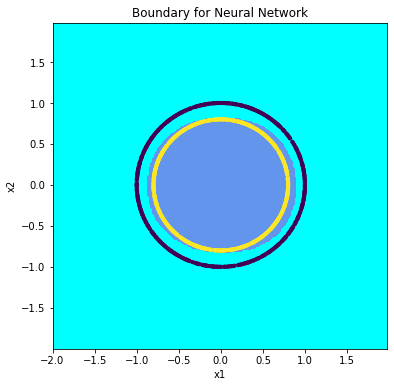

In [184]:
# nnmodel(torch.FloatTensor([[1,2]]))
x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = nnmodel(torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()]))

# Put the result into a color plot
#print(Z)
Z = np.array([i[1]>=i[0] for i in Z])
Z = Z.reshape(xx.shape)
plt.figure(figsize=(6, 6))
plt.contourf(xx, yy, Z, cmap= cmap_light)

# Plot also the training points
plt.scatter(x=x_train[:, 0], y=x_train[:, 1], c=y_train, s=10)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("Boundary for Neural Network")
plt.xlabel("x1")
plt.ylabel("x2")

plt.show()

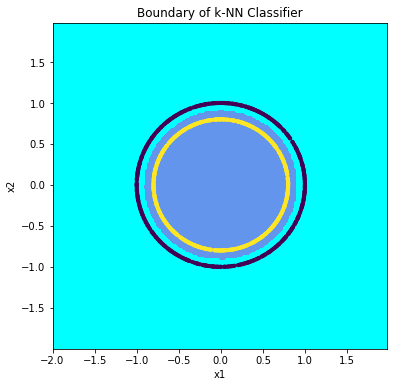

In [185]:
neigh = KNeighborsClassifier(n_neighbors=10)
neigh.fit(x_train, y_train)
x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = neigh.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot

Z = Z.reshape(xx.shape)
plt.figure(figsize=(6, 6))
plt.contourf(xx, yy, Z, cmap= cmap_light)

# Plot also the training points
plt.scatter(x=x_train[:, 0], y=x_train[:, 1], c=y_train, s=10)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("Boundary of k-NN Classifier")
plt.xlabel("x1")
plt.ylabel("x2")

plt.show()

In [248]:
from sklearn.datasets import load_breast_cancer
import sklearn.preprocessing
data = load_breast_cancer()
whole = data.data
whole = (whole - whole.mean()) / whole.std()
labels = data.target
labels = (labels - 0.5)*2
x_train = whole[:400]
y_train = labels[:400]
x_test = whole[400:]
y_test = labels[400:]

In [209]:
#Linear SVM
model = nn.Linear(30, 1)
model.cuda()
model.train()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train(x_train, y_train, model, epochs=200)
#visualize(x_train, y_train, model, "Linear SVM")
acc = test_model(x_test, y_test, model)
acc

0.9467455621301775

In [266]:
#Logistic Regression
lr = LogisticRegression(30,1)
optimizer = optim.Adam(lr.parameters(), lr=0.0001)
lr.train()
batchsize = 10
N = 400
for epoch in range(400):
    perm = torch.randperm(N)
    sum_loss = 0
    for i in range(0, 400, batchsize):
        x = torch.FloatTensor(x_train[perm[i : i + batchsize]])
        y = torch.Tensor(y_train[perm[i : i + batchsize]])
        yb = (y+1)/2
        optimizer.zero_grad()
        output = lr(x)
        weight = lr.linear.weight.squeeze()
        #print(output)
        loss = -torch.mean(yb*torch.log(output)+(1-yb)*torch.log(1-output))
        loss += 0.01*(weight.t() @ weight) / 2.0
        # Backpropagation
        loss.backward()
        optimizer.step()
#visualize(x_train, y_train, lr.linear, "Linear Logistic Regression")
output = lr(torch.FloatTensor(x_test))
#print(output)
y_pred = [i>=0.5 for i in output]
y_b = (y_test+1)/2
acc = (sum(y_b == y_pred)/len(y_b))
acc

<ipython-input-266-12a152e9e8cc>:28: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  acc = (sum(y_b == y_pred)/len(y_b))
<ipython-input-266-12a152e9e8cc>:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  acc = (sum(y_b == y_pred)/len(y_b))


0.7928994082840237

In [269]:
KSVM = KernelSvmClassifier(C=0.001, kernel=RBF)
KSVM.fit(x_train, y_train)
y_pred = KSVM.predict(x_test)
(y_test == y_pred).sum()/len(y_test)

0.9408284023668639

In [290]:
KSVM = KernelSvmClassifier(C=0.001, kernel=poly)
KSVM.fit(x_train, y_train)
y_pred = KSVM.predict(x_test)
(y_test == y_pred).sum()/len(y_test)

0.9467455621301775

In [301]:
nnmodel = NNModel(30,2)
optimizer = optim.Adam(nnmodel.parameters(), lr=0.001)
nnmodel.train()

losses = []
batchsize = 20
for epoch in range(100):
    for i in range(0, 400, batchsize):
        x = torch.FloatTensor(x_train[i : i + batchsize])
        y = torch.Tensor(y_train[i : i + batchsize])
        yb = (y+1)/2
        optimizer.zero_grad()
        y_pred = nnmodel(x) 
        loss = celoss(y_pred, yb.long())
        loss.backward()
        optimizer.step()
    output = nnmodel(torch.FloatTensor(x_test))
    y_pred = [i[1]>=i[0] for i in output]
    y_b = (y_test+1)/2
    losses.append(sum(y_b == y_pred)/len(y_b))
    print(losses[-1])

C:\Users\46145\anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
<ipython-input-171-398bdfac6018>:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(z)


0.7692307692307693
0.8402366863905325
0.9112426035502958
0.9230769230769231
0.9289940828402367
0.9349112426035503
0.9349112426035503
0.9349112426035503
0.9408284023668639
0.9289940828402367
0.9349112426035503
0.9408284023668639
0.9526627218934911
0.9526627218934911
0.9526627218934911
0.9526627218934911
0.9526627218934911
0.9526627218934911
0.9526627218934911
0.9467455621301775
0.9467455621301775
0.9467455621301775
0.9467455621301775
0.9467455621301775
0.9408284023668639
0.9408284023668639
0.9408284023668639
0.9408284023668639
0.9408284023668639
0.9289940828402367
0.9289940828402367
0.9289940828402367
0.9289940828402367
0.9289940828402367
0.9289940828402367
0.9289940828402367
0.9289940828402367
0.9230769230769231
0.9289940828402367
0.9289940828402367
0.9289940828402367
0.9289940828402367
0.9289940828402367
0.9289940828402367
0.9289940828402367
0.9289940828402367
0.9289940828402367
0.9289940828402367
0.9289940828402367
0.9289940828402367
0.9289940828402367
0.9289940828402367
0.9289940828

In [302]:
neigh = KNeighborsClassifier(n_neighbors=10)
neigh.fit(x_train, y_train)
y_pred = neigh.predict(x_test)
(y_test == y_pred).sum()/len(y_test)

0.9408284023668639